## Importing Libraries

In [1]:
import numba.cuda
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import cv2
import glob as glob
import albumentations as A
import requests
import zipfile
import io

from PIL import Image

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import Sequence
from tensorflow.keras.optimizers import Adam, Adadelta
from tensorflow.keras.layers import (Input, Conv2D, MaxPooling2D, AveragePooling2D,
                                     Conv2DTranspose, BatchNormalization, Activation,
                                     Dropout, UpSampling2D, Concatenate, Add, SpatialDropout2D, Rescaling, Reshape, Flatten, Dense, ZeroPadding2D)
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
import tensorflow.keras.regularizers as regs
from tensorflow.keras.callbacks import Callback


from matplotlib.ticker import (MultipleLocator, FormatStrFormatter)
from dataclasses import dataclass
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

from sklearn.model_selection import train_test_split

import numba

block_plot = False
plt.rcParams['image.cmap'] = 'gray'

/opt/conda/lib/python3.10/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.18 (you have 1.4.17). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


## set seeds

In [2]:
def system_config(SEED_VALUE):

    os.environ["CUDA_VISIBLE_DEVICES"] = '0'
    os.environ['TF_CUDNN_DETERMINISTIC'] = '1' 

    device = numba.cuda.get_current_device()
    device.reset()

    np.random.seed(SEED_VALUE)
    tf.random.set_seed(SEED_VALUE)
    
    # Get list of GPUs.
    gpu_devices = tf.config.list_physical_devices('GPU')
    print(gpu_devices)
    
    if len(gpu_devices) > 0:
        print('Using GPU')
        
        # If there are any gpu devices, use first gpu.
        tf.config.experimental.set_visible_devices(gpu_devices[0], 'GPU')
        
        # Grow the memory usage as it is needed by the process.
        tf.config.experimental.set_memory_growth(gpu_devices[0], True)
        
        # Enable using cudNN.
        os.environ['TF_USE_CUDNN'] = "true"

    else:
        print('Using CPU')


## Configurations

In [3]:
@dataclass(frozen=True)
class DatasetConfig:
    NUM_CLASSES: int = 10
    IMG_WIDTH:   int = 640
    IMG_HEIGHT:  int = 480
    DATA_IMAGES: str = '/kaggle/input/project-3/dataset/train/images/*.jpg' #20 epochs warmup on 32, 16 and 4 decimated images before main training
    DATA_LABELS: str = '/kaggle/input/project-3/dataset/train/masks/*.png'
    DATA_TEST_IMAGES:  str = '/kaggle/input/project-3/dataset/test/images/*.jpg'
        
@dataclass(frozen=True)
class TrainingConfig:
    BATCH_SIZE:      int = 2
    EPOCHS:          int = 40
    LEARNING_RATE: float = 0.001
    LOG_DIR:  str = 'Training_Logs'

## Helper Functions

In [4]:
id2color = {
    0: (0,   0,     0),   #Background
    1: (255,   0,   0),   #Building Flooded
    2: (200,  90,  90),   #Building Non-Flooded
    3: (128,   128, 0),   #Road Flooded
    4: (155, 155, 155),   #Road Non-Flooded
    5: (0,   255, 255),   #Water
    6: (55,    0, 255),   #Tree
    7: (255,   0, 255),   #Vehicle
    8: (245, 245,   0),   #Pool
    9: (0,   255,   0),   #Grass
 }

def rgb_to_onehot(rgb_arr, color_map, num_classes):
    
    shape = rgb_arr.shape[:2] + (num_classes,)
    arr = np.zeros( shape, dtype=np.float32 )
    
    for i, classes in enumerate(color_map):
        arr[:,:,i] = np.all(rgb_arr.reshape( (-1,3) ) == color_map[i], axis=1).reshape(shape[:2])
        
    return arr

def num_to_rgb(num_arr, color_map):
    
    single_layer = np.squeeze(num_arr)
    output = np.zeros(num_arr.shape[:2]+(3,))
    
    for k in color_map.keys():
        output[single_layer==k] = color_map[k]
        
    return np.float32(output) / 255. # return a floating point array in range [0.0, 1.0]

def image_overlay(image, segmented_image):
    
    alpha = 1.0 # Transparency for the original image.
    beta  = 0.7 # Transparency for the segmentation map.
    gamma = 0.0 # Scalar added to each sum.
    
    segmented_image = cv2.cvtColor(segmented_image, cv2.COLOR_RGB2BGR)
    
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    
    image = cv2.addWeighted(image, alpha, segmented_image, beta, gamma, image)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    return np.clip(image, 0.0, 1.0)

def display_image_and_mask(data_list, color_mask, color_map):
    
    plt.figure(figsize=(16, 6))
    title = ['GT Image', 'GT Mask', 'Overlayed Mask']

    grayscale_gt_mask = data_list[1]
    
    # Create RGB segmentation map from grayscale segmentation map.
    rgb_gt_mask = num_to_rgb(data_list[1], color_map=color_map)
    
    # Create the overlayed image.
    overlayed_image = image_overlay(data_list[0], rgb_gt_mask)
    
    data_list.append(overlayed_image)
    
    for i in range(len(data_list)):
        plt.subplot(1, len(data_list), i+1)
        plt.title(title[i])
        if title[i] == 'GT Mask':
            if color_mask:
                plt.imshow(np.array(rgb_gt_mask))
            else:
                plt.imshow(np.array(grayscale_gt_mask))
        else:
            plt.imshow(np.array(data_list[i]))
        plt.axis('off')
        
    plt.show()

## Data Loader

In [5]:
class CustomSegDataLoader(Sequence):
    
    def __init__(self, *, batch_size, image_size, image_paths, mask_paths, num_classes, aug):
        
        self.batch_size  = batch_size
        self.image_size  = image_size
        self.image_paths = image_paths
        self.mask_paths  = mask_paths
        self.num_classes = num_classes
        self.aug = aug
        
        self.x = np.empty((self.batch_size,) + self.image_size + (3,), dtype="float32")
        self.y = np.empty((self.batch_size,) + self.image_size, dtype="float32")
        
        if self.aug:
            self.train_transforms = self.transforms()
        
        self.resize_transforms = self.resize()
        
    def __len__(self):
        
        return len(self.mask_paths) // self.batch_size

    def transforms(self):
        
        train_transforms = A.Compose([
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.ShiftScaleRotate(scale_limit=0.2, rotate_limit=30, 
                               shift_limit=0.2, p=0.5, border_mode=0),
            A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=0.5)
        ])
        return train_transforms
    
    def resize(self):
        
        resize_transforms = A.Resize(
            height=self.image_size[0], width=self.image_size[1],
            interpolation=cv2.INTER_NEAREST,
            always_apply=True, p=1
        )
        return resize_transforms
    
    def reset_array(self):
        self.x.fill(0.)
        self.y.fill(0.)

    def __getitem__(self, idx):
        self.reset_array()
        i = idx * self.batch_size
        batch_image_paths = self.image_paths[i : i + self.batch_size]
        batch_mask_paths = self.mask_paths[i : i + self.batch_size]
        
        for j, (input_image, input_mask) in enumerate(zip(batch_image_paths, batch_mask_paths)):

            img = cv2.imread(input_image)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            
            msk = cv2.imread(input_mask)
            msk = cv2.cvtColor(msk, cv2.COLOR_BGR2RGB)

            resized  = self.resize_transforms(image=img, mask=msk)
            img, msk = resized['image'], resized['mask']
            
            if self.aug:
                train_augment = self.train_transforms(image=img, mask=msk)
                img, msk = train_augment['image'], train_augment['mask']

            self.x[j] = img 
                           
            msk = rgb_to_onehot(msk, id2color, 10)
            
            self.y[j] = msk.argmax(-1)
            
        return self.x, self.y

## Creating dataset for training

In [6]:

def create_datasets(dataset_config : DatasetConfig, training_config : TrainingConfig, aug=False):
    
    # Training image and mask paths.
    all_images = sorted(glob.glob(dataset_config.DATA_IMAGES))
    all_masks  = sorted(glob.glob(dataset_config.DATA_LABELS))
    
    im_train, im_valid, mk_train, mk_valid = train_test_split(all_images, all_masks, test_size=0.2, random_state=42)

    # Train data loader.
    train_ds = CustomSegDataLoader(batch_size=training_config.BATCH_SIZE,
                                   image_size=(dataset_config.IMG_HEIGHT, dataset_config.IMG_WIDTH),
                                   image_paths=im_train,
                                   mask_paths=mk_train,
                                   num_classes=dataset_config.NUM_CLASSES,
                                   aug=aug,
                                  )

    valid_ds = CustomSegDataLoader(batch_size=training_config.BATCH_SIZE,
                                   image_size=(dataset_config.IMG_HEIGHT, dataset_config.IMG_WIDTH),
                                   image_paths=im_valid,
                                   mask_paths=mk_valid,
                                   num_classes=dataset_config.NUM_CLASSES,
                                   aug=False,
                                  )
    
    return train_ds, valid_ds

In [7]:
data_config = DatasetConfig()
train_config = TrainingConfig()

train_ds, valid_ds = create_datasets(data_config, train_config, aug=True)

## visualize validation data

image, mask:  (480, 640, 3) (480, 640)
image, mask:  (480, 640, 3) (480, 640)
image, mask:  (480, 640, 3) (480, 640)


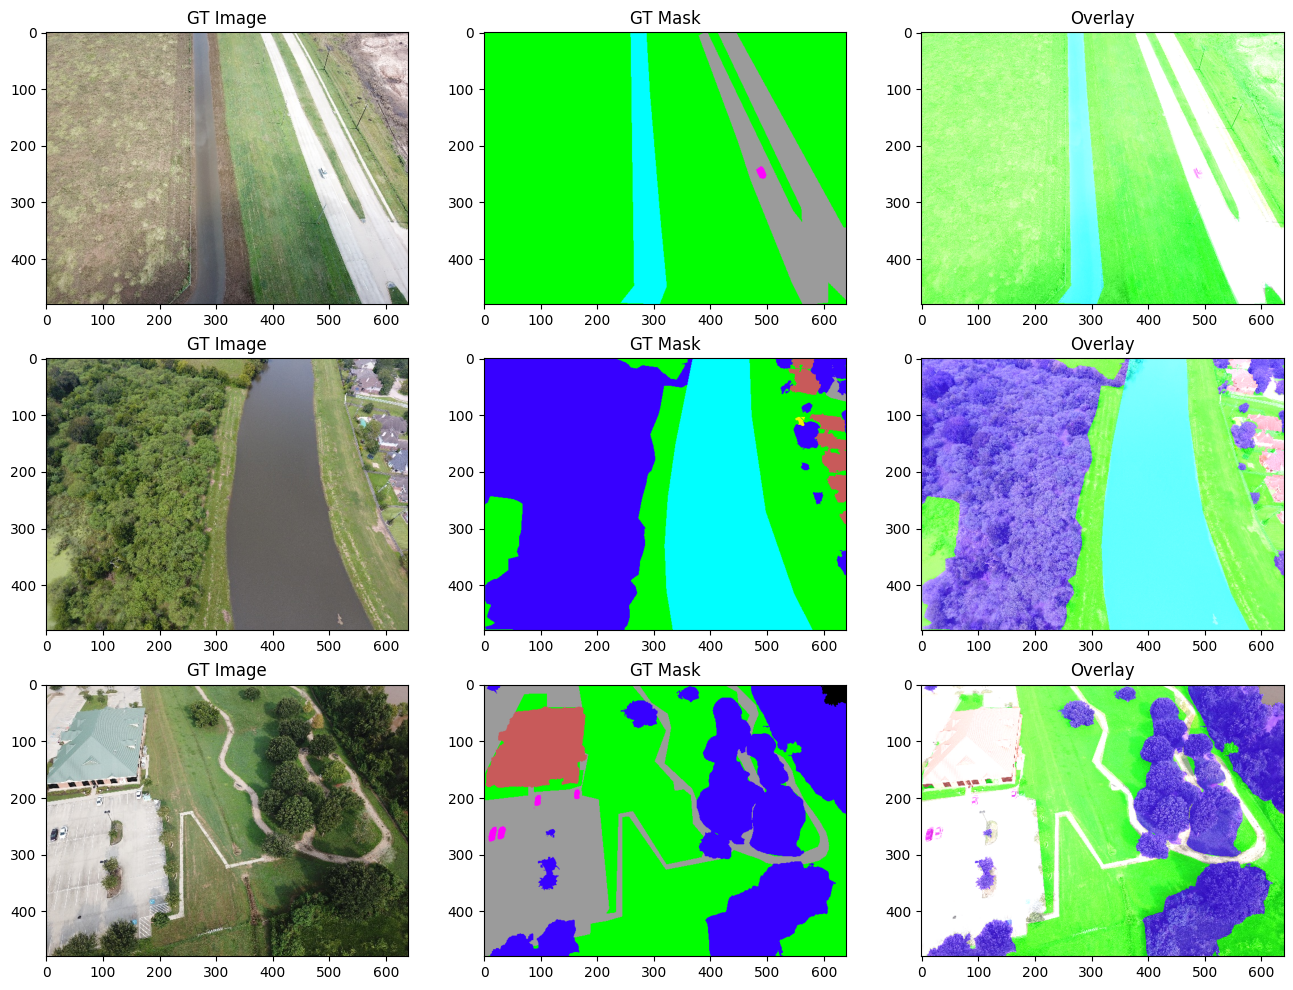

In [8]:


f, ax = plt.subplots(3, 3)

f.set_size_inches(16, 12)

for i, (images, masks) in enumerate(valid_ds): #Using validation set because the training set might contain augmented images
    if i == 3:
        break
    image, mask = images[0], masks[0]
    print("image, mask: ", image.shape, mask.shape)
    image_copy = np.copy(image)
    image_copy = image_copy.astype(np.uint8)
    
    rgb_mask = num_to_rgb(mask, id2color)*255
    rgb_mask = rgb_mask.astype(np.uint8)

    vismat = image_overlay(image/255, num_to_rgb(mask, id2color))
    vismat = vismat*255
    vismat = vismat.astype(np.uint8)

    ax[i, 0].imshow(image_copy)
    ax[i, 0].set_title("GT Image")

    ax[i, 1].imshow(rgb_mask)
    ax[i, 1].set_title("GT Mask")

    ax[i, 2].imshow(vismat)
    ax[i, 2].set_title("Overlay")

plt.show()

## Loss Function

In [9]:
def tversky_loss(y_true, y_pred):

    jaccard = 1.0 - mean_iou(y_true, y_pred)

    num_classes = y_pred.shape[-1]
    
    alpha = 0.5
    beta = 0.5

    y_true = tf.one_hot(tf.cast(y_true, tf.int32), num_classes, axis=-1)

    y_true = tf.cast(y_true, y_pred.dtype)

    ones = tf.ones_like(y_true)

    p0 = y_pred
    p1 = ones - y_pred
    g0 = y_true
    g1 = ones - y_true

    num = tf.reduce_sum(p0*g0, axis=(0, 1, 2))
    denom = num + alpha*tf.reduce_sum(p0*g1, axis=(0, 1, 2)) + beta*tf.reduce_sum(p1*g0, axis=(0, 1, 2))

    tversky = tf.reduce_sum(num/denom)

    CCE =  tf.keras.losses.categorical_crossentropy(y_true, y_pred)

    return tf.cast(num.shape[0], tf.float32) - tversky + CCE + jaccard



## Metrcis

In [10]:
def dice_coef(y_true, y_pred):

    num_classes = y_pred.shape[-1]
    
    y_true_internal = tf.one_hot(tf.cast(y_true, tf.int32), num_classes, axis=-1)
    
    axes = (1, 2)
    
    intersection = tf.math.reduce_sum(y_true_internal * y_pred, axis=axes)
    
    total = tf.math.reduce_sum(y_true_internal, axis=axes) + tf.math.reduce_sum(y_pred, axis=axes)
    
    dc = tf.where(total > 0, 2.0*intersection/total, 1.0)
    
    dc_mean = tf.math.reduce_mean(dc)
    
    return dc_mean

def mean_iou(y_true, y_pred):

    num_classes = y_pred.shape[-1]

    y_true_internal = tf.one_hot(tf.cast(y_true, tf.int32), num_classes, axis=-1)
    y_pred_internal = tf.one_hot(tf.math.argmax(y_pred, axis=-1), num_classes, axis=-1)

    axes = (1, 2)

    intersection = tf.math.reduce_sum(y_true_internal * y_pred_internal, axis=axes)

    total = tf.math.reduce_sum(y_true_internal, axis=axes) + tf.math.reduce_sum(y_pred_internal, axis=axes)

    union = total - intersection

    is_class_present =  tf.cast(tf.math.not_equal(total, 0), dtype=tf.float32)

    num_classes_present = tf.math.reduce_sum(is_class_present, axis=1)

    iou = tf.math.divide_no_nan(intersection, union)

    iou = tf.math.reduce_sum(iou, axis=1) / num_classes_present
    
    mean_iou = tf.math.reduce_mean(iou)
    
    return mean_iou

## Model

In [11]:
def convolution_block(block_input, num_filters=256, kernel_size=3, dilation_rate=1, padding="same", use_bias=False, dropout_rate=0.35, regularizer=-1):
    
    if regularizer < 0:
        x = Conv2D(num_filters, kernel_size=kernel_size, dilation_rate=dilation_rate, padding=padding, use_bias=use_bias)(block_input)
    else:
        x = Conv2D(num_filters, kernel_size=kernel_size, dilation_rate=dilation_rate, padding=padding, use_bias=use_bias, kernel_regularizer=regs.l2(regularizer))(block_input)

    x = BatchNormalization()(x)
    
    x = SpatialDropout2D(dropout_rate)(x)

    return Activation('relu')(x)

In [12]:
def DilatedSpatialPyramidPooling(dspp_input, num_filters=256):
    
    dims = dspp_input.shape
    
    # Create a 1x1 feature map using AveragePooling2D.
    x = AveragePooling2D(pool_size=(dims[1], dims[2]))(dspp_input)
    x = convolution_block(x, num_filters=num_filters, kernel_size=1, use_bias=True)
    
    # Upsample the feature map to the original size.
    out_pool = UpSampling2D(size=(dims[1], dims[2]), interpolation="bilinear")(x)

    # Create feature maps of the same shape with different dilation rates.
    out_1  = convolution_block(dspp_input, num_filters=num_filters, kernel_size=1, dilation_rate=1)
    out_5  = convolution_block(dspp_input, num_filters=num_filters, kernel_size=3, dilation_rate=5)
    out_10 = convolution_block(dspp_input, num_filters=num_filters, kernel_size=3, dilation_rate=10)
    out_15 = convolution_block(dspp_input, num_filters=num_filters, kernel_size=3, dilation_rate=15)
    out_20 = convolution_block(dspp_input, num_filters=num_filters, kernel_size=3, dilation_rate=20)

    # Combine all the feature maps and process them through a 1x1 convolutional block.
    x = Concatenate(axis=-1)([out_pool, out_1, out_5, out_10, out_15, out_20])
    output = convolution_block(x, num_filters=num_filters, kernel_size=1)
    
    return output

In [13]:
def get_model(num_classes, shape):

    model_input = Input(shape=shape)

    backbone = tf.keras.applications.EfficientNetV2S(include_top=False, weights="imagenet", input_tensor=model_input)
    backbone.trainable = True

    # Shape: (15, 20, 1536)
    input_a = backbone.get_layer("block6b_expand_activation").output
    input_a = DilatedSpatialPyramidPooling(input_a, num_filters=256)
    input_a = UpSampling2D(size=(16, 16), interpolation="bilinear")(input_a)
    
    #Shape: (30, 40, 512)
    input_b = backbone.get_layer("block4b_expand_activation").output
    input_b = DilatedSpatialPyramidPooling(input_b, num_filters=256)
    input_b = UpSampling2D(size=(8, 8), interpolation="bilinear")(input_b)

    # Shape: (60, 80, 256)
    input_c = backbone.get_layer("block3b_expand_activation").output
    input_c = convolution_block(input_c, num_filters=256, kernel_size=1)
    input_c = UpSampling2D(size=(4, 4), interpolation="bilinear")(input_c)

    #Shape: (120, 160, 192)
    input_d = backbone.get_layer("block2b_expand_activation").output
    input_d = convolution_block(input_d, num_filters=256, kernel_size=1)
    input_d = UpSampling2D(size=(2, 2), interpolation="bilinear")(input_d)


    x = Concatenate()([input_a, input_b, input_c, input_d])

    x = convolution_block(x)
    x = convolution_block(x)
    x = UpSampling2D(size=(2, 2), interpolation="bilinear")(x)

    outputs = Conv2D(num_classes, kernel_size=(1, 1), padding="valid", activation="softmax")(x)

    model = Model(inputs=model_input, outputs=outputs)

    return model

In [14]:
class EpochImages(Callback):
    def __init__(self, log_dir="./logs"):
        super().__init__()
        self.log_dir = log_dir
        self.writer = tf.summary.create_file_writer(self.log_dir)

    def on_epoch_end(self, epoch, logs=None):
        with self.writer.as_default():

            img = cv2.imread("/kaggle/input/project-3/dataset/test/images/6703.jpg")
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            img_proc = img #in case it required an out of model preprocessing

            img_proc = np.expand_dims(img_proc, axis=0)

            out_mask = self.model.predict(img_proc)
            out_mask = np.squeeze(out_mask, axis=0)
            out_mask = np.argmax(out_mask, axis=2)
            out_mask = num_to_rgb(out_mask, id2color)

            # img = np.squeeze(img, axis=0)
            img_fl = img.astype(np.float32)/255.0

            img_ov = image_overlay(img_fl, out_mask)
            img = img.astype(np.float32)/255.0

            vismat1 = np.zeros((2*img.shape[0], 3*img.shape[1] + 3, 3), dtype=np.float32)
            vismat1[:img.shape[0], :img.shape[1], :] = img
            vismat1[:img.shape[0], img.shape[1] + 1:2*img.shape[1] + 1, :] = out_mask
            vismat1[:img.shape[0], 2*img.shape[1] + 2:3*img.shape[1] + 2, :] = img_ov

            img = cv2.imread("/kaggle/input/project-3/dataset/test/images/6468.jpg")
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            img_proc = img

            img_proc = np.expand_dims(img_proc, axis=0)

            out_mask = self.model.predict(img_proc)
            out_mask = np.squeeze(out_mask, axis=0)
            out_mask = np.argmax(out_mask, axis=2)
            out_mask = num_to_rgb(out_mask, id2color)

            # img = np.squeeze(img, axis=0)
            img_fl = img.astype(np.float32)/255.0

            img_ov = image_overlay(img_fl, out_mask)
            img = img.astype(np.float32)/255.0

            vismat2 = np.zeros((2*img.shape[0], 3*img.shape[1] + 3, 3), dtype=np.float32)
            vismat2[:img.shape[0], :img.shape[1], :] = img
            vismat2[:img.shape[0], img.shape[1] + 1:2*img.shape[1] + 1, :] = out_mask
            vismat2[:img.shape[0], 2*img.shape[1] + 2:3*img.shape[1] + 2, :] = img_ov


            img = cv2.imread("/kaggle/input/project-3/dataset/train/images/7604.jpg")
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            img_proc = img

            img_proc = np.expand_dims(img_proc, axis=0)

            out_mask = self.model.predict(img_proc)
            out_mask = np.squeeze(out_mask, axis=0)
            out_mask = np.argmax(out_mask, axis=2)
            out_mask = num_to_rgb(out_mask, id2color)

            # img = np.squeeze(img, axis=0)
            img_fl = img.astype(np.float32)/255.0

            true_mask = cv2.imread("/kaggle/input/project-3/dataset/train/masks/7604.png")
            true_mask = cv2.cvtColor(true_mask, cv2.COLOR_BGR2RGB).astype(np.float32)/255.0

            img_ov = image_overlay(img_fl, out_mask)
            img_ov2 = image_overlay(img_fl, true_mask)
            img = img.astype(np.float32)/255.0

            vismat3 = np.zeros((2*img.shape[0], 3*img.shape[1] + 3, 3), dtype=np.float32)
            vismat3[:img.shape[0], :img.shape[1], :] = img
            vismat3[:img.shape[0], img.shape[1] + 1:2*img.shape[1] + 1, :] = out_mask
            vismat3[:img.shape[0], 2*img.shape[1] + 2:3*img.shape[1] + 2, :] = img_ov

            vismat3[img.shape[0]:, :img.shape[1], :] = img
            vismat3[img.shape[0]:, img.shape[1] + 1:2*img.shape[1] + 1, :] = true_mask
            vismat3[img.shape[0]:, 2*img.shape[1] + 2:3*img.shape[1] + 2, :] = img_ov2

            out_vec = [vismat1, vismat2, vismat3]

            tf.summary.image("Epoch images", out_vec, step=epoch)
        self.writer.flush()

In [15]:
train_model = True
generate_warmup_data = False
load_model = False

system_config(7)

version_dir = os.path.join(TrainingConfig.LOG_DIR, "Checkpoints", "version_0")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Using GPU


## Training Model

In [16]:
train_ds, valid_ds = create_datasets(data_config, train_config, aug=True)

model = get_model(num_classes=DatasetConfig.NUM_CLASSES, shape=(DatasetConfig.IMG_HEIGHT, DatasetConfig.IMG_WIDTH, 3))
                    
model.summary()

optimizer = Adam(learning_rate=TrainingConfig.LEARNING_RATE)

if not load_model:
    model.compile(optimizer=optimizer, loss=tversky_loss, metrics=['accuracy', dice_coef, mean_iou])

if not os.path.exists(TrainingConfig.LOG_DIR):
    os.makedirs(TrainingConfig.LOG_DIR)

if not os.path.exists(version_dir):
    os.makedirs(version_dir)
    
checkpoint_filepath = os.path.join(version_dir, 'model_checkpoint.keras')

# Callback to save the best model based on validation loss.
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath,
                                                            save_weights_only=False,
                                                            monitor='val_loss',
                                                            mode='min',
                                                            save_best_only=True,
                                                            verbose=1
                                                            )

tb_logdir = os.path.join(TrainingConfig.LOG_DIR, "TB_Logs")

tensorboard_callback = tf.keras.callbacks.TensorBoard(
        log_dir=tb_logdir,
        histogram_freq=5,
        write_graph=True,
        update_freq="epoch",
        write_images=True,
    )


82420632/82420632 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 480, 640,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 480, 640,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 240, 320,  │        648 │ rescaling[0][0]   │
│                     │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 240, 320,  │         96 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 240, 320,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 240, 320,  │      5,184 │ stem_activation[… │
│ (Conv2D)            │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_bn  │ (None, 240, 320,  │         96 │ block1a_project_… │
│ (BatchNormalizatio… │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_ac… │ (None, 240, 320,  │          0 │ block1a_project_… │
│ (Activation)        │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_add (Add)   │ (None, 240, 320,  │          0 │ block1a_project_… │
│                     │ 24)               │            │ stem_activation[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_co… │ (None, 240, 320,  │      5,184 │ block1a_add[0][0] │
│ (Conv2D)            │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_bn  │ (None, 240, 320,  │         96 │ block1b_project_… │
│ (BatchNormalizatio… │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_ac… │ (None, 240, 320,  │          0 │ block1b_project_… │
│ (Activation)        │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_drop        │ (None, 240, 320,  │          0 │ block1b_project_… │
│ (Dropout)           │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_add (Add)   │ (None, 240, 320,  │          0 │ block1b_drop[0][… │
│                     │ 24)               │            │ block1a_add[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_conv │ (None, 120, 160,  │     20,736 │ block1b_add[0][0] │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_bn   │ (None, 120, 160,  │        384 │ block2a_expand_c… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_act… │ (None, 120, 160,  │          0 │ block2a_expand_b

 Total params: 30,027,754 (114.55 MB)

 Trainable params: 29,957,338 (114.28 MB)

 Non-trainable params: 70,416 (275.06 KB)

In [17]:
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import AdamW

# AdamW optimizer with weight decay
optimizer = AdamW(learning_rate=1e-3, weight_decay=1e-5)

# Learning rate scheduler to reduce LR on plateau
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)

# Define callbacks
#early_stopping = EarlyStopping(monitor='val_dice_coef', patience=20, mode='max', restore_best_weights=True, verbose=1, min_delta=1e-4)


In [18]:

history = model.fit(train_ds,
                    epochs=TrainingConfig.EPOCHS,
                    verbose=1,
                    validation_data=valid_ds,
                    callbacks=[model_checkpoint_callback, tensorboard_callback, EpochImages(log_dir=tb_logdir), lr_scheduler],
                )

Epoch 1/40


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1728552868.660345     108 service.cc:145] XLA service 0x7b3958003800 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1728552868.660393     108 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1728553014.946179     108 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_4', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_3', 4 bytes spill stores, 12 bytes spill 

737/737 ━━━━━━━━━━━━━━━━━━━━ 0s 467ms/step - accuracy: 0.6824 - dice_coef: 0.2254 - loss: 8.9685 - mean_iou: 0.2792

/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()



Epoch 1: val_loss improved from inf to 25.52085, saving model to Training_Logs/Checkpoints/version_0/model_checkpoint.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
737/737 ━━━━━━━━━━━━━━━━━━━━ 677s 618ms/step - accuracy: 0.6825 - dice_coef: 0.2254 - loss: 8.9677 - mean_iou: 0.2792 - val_accuracy: 0.0210 - val_dice_coef: 0.0036 - val_loss: 25.5208 - val_mean_iou: 0.0073 - learning_rate: 0.0010
Epoch 2/40
737/737 ━━━━━━━━━━━━━━━━━━━━ 0s 471ms/step - accuracy: 0.7829 - dice_coef: 0.2884 - loss: 7.5633 - mean_iou: 0.3418
Epoch 2: val_loss did not improve from 25.52085
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
737/737 ━━━━━━━━━━━━━━━━━━━━ 425s 573ms/step - accuracy: 0.7829 - dice_coef: 0.2884 - loss: 7.5631 - mean_iou: 0.3418 - val_accuracy: 0.0219 - val_dice_coef: 0.0039 - val_loss: 30.0975 - val_mean_iou: 0.0089 - learning_rate: 0.0010
Epoch 3/40

## Plot Results

In [19]:
def plot_results(metrics, ylabel=None, ylim=None, metric_name=None, color=None):

    fig, ax = plt.subplots(figsize=(18, 5))

    if not (isinstance(metric_name, list) or isinstance(metric_name, tuple)):
        metrics = [metrics,]
        metric_name = [metric_name,]

    for idx, metric in enumerate(metrics):
        ax.plot(metric, color=color[idx])

    plt.xlabel("Epoch")
    plt.ylabel(ylabel)
    plt.title(ylabel)
    plt.xlim([0, TrainingConfig.EPOCHS-1])
    plt.ylim(ylim)
    # Tailor x-axis tick marks
    ax.xaxis.set_major_locator(MultipleLocator(5))
    ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))
    ax.xaxis.set_minor_locator(MultipleLocator(1))
    plt.grid(True)
    plt.legend(metric_name)
    plt.show(block=block_plot)
    plt.close()

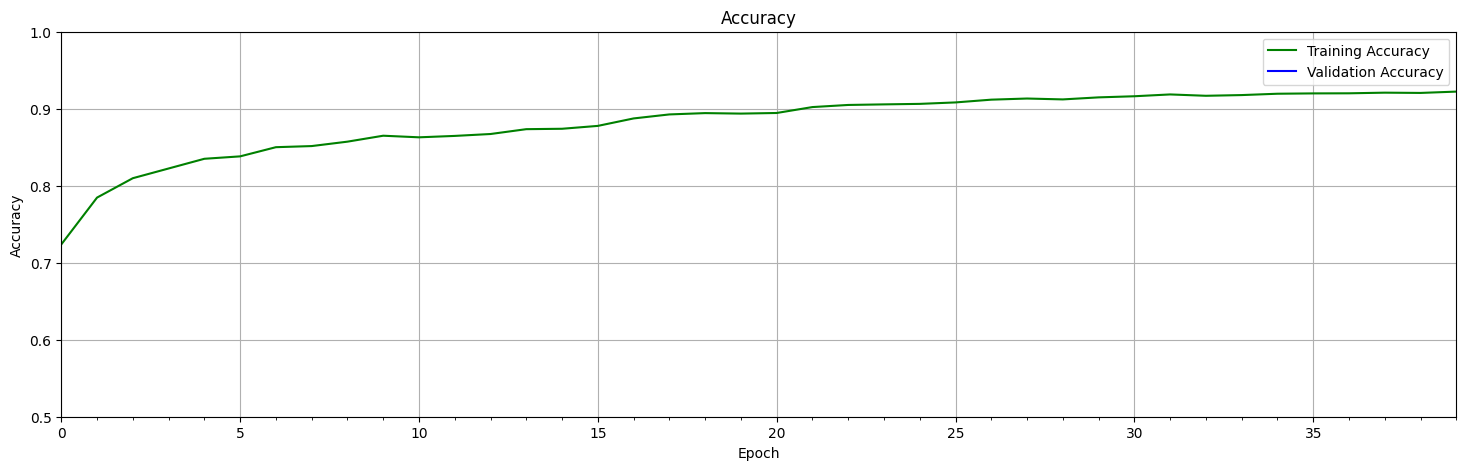

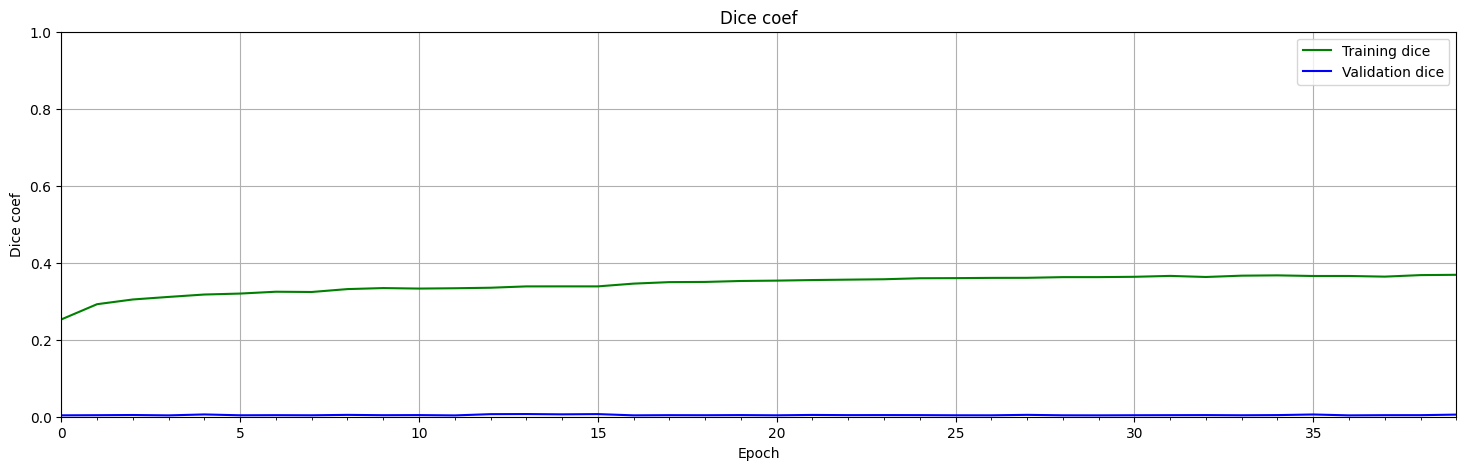

In [20]:
# Pixel accuracy
train_acc = history.history["accuracy"]
valid_acc = history.history["val_accuracy"]

# DICE COEF
train_coef = history.history["dice_coef"]
valid_coef = history.history["val_dice_coef"]


plot_results([ train_acc, valid_acc ],
            ylabel="Accuracy",
            ylim = [0.5, 1.0],
            metric_name=["Training Accuracy", "Validation Accuracy"],
            color=["g", "b"])

plot_results([ train_coef, valid_coef ],
            ylabel="Dice coef",
            ylim = [0.0, 1.0],
            metric_name=["Training dice", "Validation dice"],
            color=["g", "b"])

## Evaluation

In [22]:
trained_model = tf.keras.models.load_model(checkpoint_filepath, custom_objects={'dice_coef':dice_coef,
                                                                        'tversky_loss': tversky_loss,
                                                                             'mean_iou'  :mean_iou})

In [23]:
evaluate = trained_model.evaluate(valid_ds)

print(f"Model evaluation accuracy:  {evaluate[1]*100.:.3f}")
print(f"Model evaluation dice coef:  {evaluate[2]*100.:.3f}")

184/184 ━━━━━━━━━━━━━━━━━━━━ 63s 270ms/step - accuracy: 0.0201 - dice_coef: 0.0033 - loss: 21.3043 - mean_iou: 0.0060
Model evaluation accuracy:  2.163
Model evaluation dice coef:  0.425


In [24]:
@dataclass(frozen=True)
class InferenceConfig:
    NUM_BATCHES:     int = 3

## Visualise the result

1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


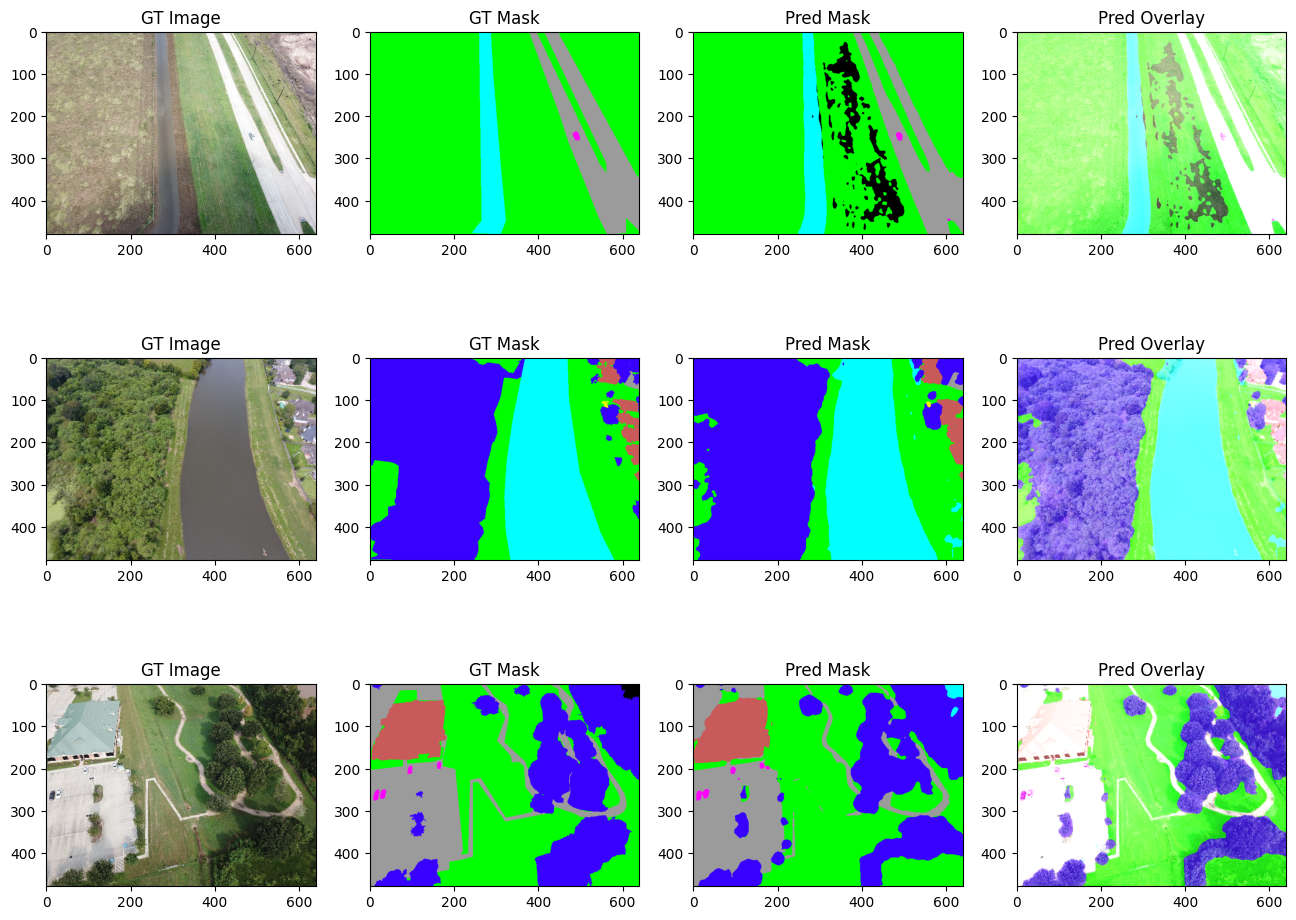

In [27]:
f, ax = plt.subplots(3, 4)

f.set_size_inches(16, 12)

for i, (images, masks) in enumerate(valid_ds): #Using validation set because the training set might contain augmented images
    if i == 3:
        break
    image, gt_mask = images[0], masks[0]

    gt_mask_rgb = num_to_rgb(gt_mask, id2color)*255
    gt_mask_rgb = gt_mask_rgb.astype(np.uint8)

    image_copy = np.copy(image)

    img_proc = np.expand_dims(image_copy, axis=0)
    pred_mask = model.predict(img_proc)
    pred_mask = np.squeeze(pred_mask, axis=0)
    pred_mask = np.argmax(pred_mask, axis=2)

    pred_mask_rgb = num_to_rgb(pred_mask, id2color)*255
    pred_mask_rgb = pred_mask_rgb.astype(np.uint8)

    vismat = image_overlay(image/255, num_to_rgb(pred_mask, id2color))
    vismat = vismat*255
    vismat = vismat.astype(np.uint8)

    image_copy = image_copy.astype(np.uint8)

    ax[i, 0].imshow(image_copy)
    ax[i, 0].set_title("GT Image")

    ax[i, 1].imshow(gt_mask_rgb)
    ax[i, 1].set_title("GT Mask")

    ax[i, 2].imshow(pred_mask_rgb)
    ax[i, 2].set_title("Pred Mask")

    ax[i, 3].imshow(vismat)
    ax[i, 3].set_title("Pred Overlay")

plt.show()

## Generating CSV

In [28]:
out_file = open("submission.csv", "w", encoding="utf-8")

out_file.write("IMG_ID,EncodedString\n")

cur_image = 1

test_img_fn = sorted(glob.glob(data_config.DATA_TEST_IMAGES))

for fn in test_img_fn:

    img = cv2.imread(fn)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_proc = np.copy(img)

    img_proc = np.expand_dims(img_proc, axis=0)

    out_mask = model.predict(img_proc)
    out_mask = np.squeeze(out_mask, axis=0)
    out_mask = np.argmax(out_mask, axis=2)

    out_mask = out_mask.astype(np.uint8)

    out_dict = {}
    for i in range(data_config.NUM_CLASSES):
        out_dict[i] = []

    current_class = 0
    class_counter = 0
    class_idx = 0

    for i in range(out_mask.shape[1]):
        for j in range(out_mask.shape[0]):

            if i == 0 and j == 0:
                current_class = out_mask[j, i]
                class_counter += 1
                continue

            if out_mask[j, i] == current_class:
                class_counter += 1
            else:
                out_dict[current_class].append((class_idx, class_counter))

                class_idx = out_mask.shape[0]*i + j
                class_counter = 1
                current_class = out_mask[j, i]

    
    out_string = fn.split("/")[-1].split(".")[0] + "_"
    for class_id in range(data_config.NUM_CLASSES):
        cur_str = out_string + "{:02d}".format(class_id) + ","

        for cur_tup in out_dict[class_id]:
            cur_str = cur_str + "{:d} {:d} ".format(cur_tup[0], cur_tup[1])
        
        out_file.write(cur_str + "\n")

    print("Image {:03d}/{:03d} done".format(cur_image, len(test_img_fn)))
    cur_image += 1


out_file.close()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Image 001/500 done
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Image 002/500 done
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Image 003/500 done
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Image 004/500 done
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Image 005/500 done
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Image 006/500 done
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Image 007/500 done
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Image 008/500 done
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Image 009/500 done
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Image 010/500 done
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Image 011/500 done
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Image 012/500 done
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Image 013/500 done
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Image 014/500 done
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Image 015/500 done
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Image 016/500 done
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Image 017/500 done
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27m